# This notebook will show the implementation of RangingNN for generating peaks ranges in a APT mass-to-charge spectrum

## Contents


- [Import modules](#Import-modules)
- [Load data and preprocessing](#training-data-precheck)
- [Load model and run inference](#train)
- [Visualization](#model-prediction-and-evaluation)
- [Blind validation: load .apt and export .RRNG](#Blind-validation:-load-.apt-and-export-.RRNG)


In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Clone the Github repo
!git clone https://github.com/uw-cmg/peak_detection

Cloning into 'peak_detection'...
remote: Enumerating objects: 459, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 459 (delta 1), reused 6 (delta 1), pack-reused 449 (from 1)
Receiving objects: 100% (459/459), 20.61 MiB | 19.24 MiB/s, done.
Resolving deltas: 100% (247/247), done.


In [6]:
# Install dependencies
!pip install -r "peak_detection/requirements.txt"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 MB 10.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 86.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.3 MB/s e

In [7]:
# Move repo files so imports work
import shutil
shutil.move('peak_detection', 'peak_detection_repo')
shutil.move('peak_detection_repo/peak_detection', '.')

'./peak_detection'

# Import modules

In [1]:
import apav
import os
import peak_detection
from peak_detection.RangingNN.predictor import DetectionPredictor
import numpy as np
import matplotlib.pyplot as plt
import torch
def normalize(spectrum, ranges):
    return (spectrum - spectrum.min()) / (spectrum.max() - spectrum.min()), ranges / 307.2
print(np.__version__,torch.__version__)

1.23.5 2.1.2+cu121


# Load data and preprocessing

**! change the file path according to your file directory**

**If run on colab, upload files to google drive and mount your drive first**


In [3]:
import os

data_path = 'drive/MyDrive/Cameca'
#apt_file = os.path.join(data_path, 'R13_40310Zr Unsaved - Top Level ROI.apt')
#range_file = os.path.join(data_path, 'R13_40310Zr Top Level ROI.RRNG')

apt_file = 'R13_40310Zr Unsaved - Top Level ROI.apt'
range_file = 'R13_40310Zr Top Level ROI.RRNG'

print(os.path.exists(range_file))

#apt_file = '/srv/home/jwei74/APT_ML/ranging/rawdata/R13_40310Zr Top Level ROI.apt' # change here
#range_file = '/srv/home/jwei74/APT_ML/ranging/rawdata/ExaminedRanges/R13_40310Zr Top Level ROI.RRNG' # change here

#load the apt and get histogram
d = apav.load_apt(apt_file)
x, spectrum = d.mass_histogram(bin_width=0.01, lower=0, upper=307.2, multiplicity='all', norm=False, )

#load the rrng and labeled peaks
range_label = apav.RangeCollection.from_rrng(range_file)
peakl = np.array([r.lower for r in range_label.ranges])
peakh = np.array([r.upper for r in range_label.ranges])
peaks = np.vstack((peakl, peakh)).T

spectrum_log = np.log(spectrum+1)
spectrum_log, range_gt = normalize(spectrum_log, peaks)
spectrum_log = torch.tensor(spectrum_log, dtype=torch.float32)

INFO:apav:Reading apt file: R13_40310Zr Unsaved - Top Level ROI.apt


True


INFO:apav:Reading RRNG file: R13_40310Zr Top Level ROI.RRNG


In [4]:
spectrum_log

tensor([0.0000, 0.0000, 0.0000,  ..., 0.1861, 0.1741, 0.1241])

# Load model and run inference

In [28]:
!pip install numpy==1.23.5 --force-reinstall


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 32.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lmfit 1.3.3 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
xarray 2025.1.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
pymc 5.21.2 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 whic

In [5]:
cfg = os.path.dirname(peak_detection.__file__) + '/RangingNN/cfg/prediction_args.yaml' # loading the default parameter file in the package
modelpath = os.path.join(os.path.dirname(peak_detection.__file__), 'RangingNN/modelweights', 'best.pt') # loading the default trained-model in the package
save_dir = './test' # auto save results not implemented yet

predictor = DetectionPredictor(modelpath, spectrum_log[None, None, ...], save_dir = save_dir, cfg = cfg)
result = predictor()[0]
peak_pred = result[:,:2].cpu()

Start inference
Speed:  336.5ms inference, 47.8ms postprocess for per spectrum 


# Visualization

In [6]:
# enabling interactive plot
try:
    import ipympl
except:
    !pip install ipympl
try:
    import google.colab
    from google.colab import output
    output.enable_custom_widget_manager()
    %matplotlib widget
except: # when not in google colab
    %matplotlib widget

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.7/515.7 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.6 MB/s eta 0:00:00


ValueError: Key backend: 'module://ipympl.backend_nbagg' is not a valid value for backend; supported values are ['gtk3agg', 'gtk3cairo', 'gtk4agg', 'gtk4cairo', 'macosx', 'nbagg', 'notebook', 'qtagg', 'qtcairo', 'qt5agg', 'qt5cairo', 'tkagg', 'tkcairo', 'webagg', 'wx', 'wxagg', 'wxcairo', 'agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template', 'inline']

labeled peaks: 34 ; model predicted peaks: 37


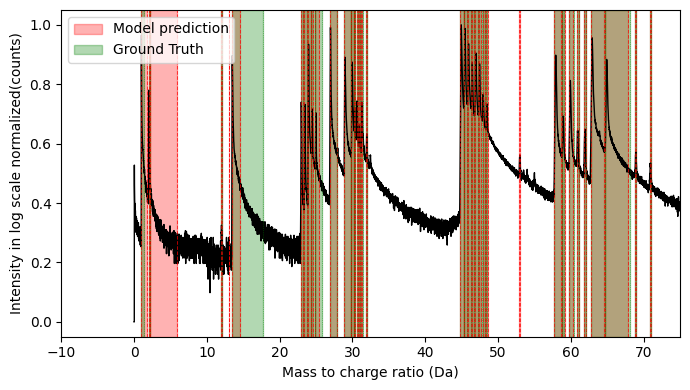

In [12]:
# set the zoom in m/c range
plot_max = 20000 # in 0.01 Da
plot_min = 0
bin_width = 0.01
peak_pred_ = peak_pred[(peak_pred[:,0] < plot_max) & (peak_pred[:,0] >plot_min)]

peaks_ = peaks / bin_width # scale the labels
peaks_ = peaks_[(peaks[:,0] < plot_max) & (peaks[:,0] >plot_min)]
print('labeled peaks:', peaks.shape[0],'; model predicted peaks:',peak_pred.shape[0] )

# Create the plot
fig, ax = plt.subplots(figsize=(7, 4))

# Plot the spectrum
x = 0.01 * torch.linspace(plot_min,plot_max, plot_max - plot_min)

ax.plot(x[...,None], spectrum_log[..., plot_min:plot_max].T, 'k-', linewidth=1)


# Add color boxes for each peak range
# Add vertical lines to show the boundaries of ranges

for start, end in peak_pred_:
    ax.axvspan(start*0.01, end*0.01, alpha=0.3, color='red',label='Model prediction' if start == peak_pred_[0][0] else "")
for start, end in peak_pred_:
    ax.axvline(start*0.01, color='red', linestyle='--', alpha=0.7, lw = 0.7)
    ax.axvline(end*0.01, color='red', linestyle='--', alpha=0.7, lw = 0.7)


for start, end in peaks_:
    ax.axvspan(start*0.01, end*0.01, alpha=0.3, color='green',label='Ground Truth'if start == peaks_[0][0] else "")
for start, end in peaks_:
    ax.axvline(start*0.01, color='green', linestyle=':', alpha=0.1, lw = 0.5)
    ax.axvline(end*0.01, color='green', linestyle=':', alpha=0.7, lw = 0.5)

# Set labels and title
ax.set_xlabel('Mass to charge ratio (Da)')
ax.set_ylabel('Intensity in log scale normalized(counts)')

ax.set_xlim(-10, 75)

# Adjust the plot layout
plt.tight_layout()
plt.legend()

# Blind validation: load .apt and export .RRNG

In [ ]:
def map01(spectrum):
    return (spectrum - spectrum.min()) / (spectrum.max() - spectrum.min())

In [ ]:
apt_file = '/srv/home/jwei74/APT_ML/ranging/VALIDATION/R6025_272235.apt'
#apt_file = '/srv/home/jwei74/APT_ML/ranging/VALIDATION/UWPIDU.apt'
#apt_file = '/srv/home/jwei74/APT_ML/ranging/VALIDATION/UWPIDW.apt'

#load the apt and get histogram
d = apav.load_apt(apt_file)
x, spectrum = d.mass_histogram(bin_width=0.01, lower=0, upper=307.2, multiplicity='all', norm=False,)

spectrum_log = np.log(spectrum+1)
spectrum_log = map01(spectrum_log)
spectrum_log = torch.tensor(spectrum_log, dtype=torch.float32)

In [ ]:
save_dir = './test'
cfg = os.path.dirname(peak_detection.__file__) + '/RangingNN/cfg/prediction_args.yaml' # loading the default parameter file in the package
modelpath = os.path.join(os.path.dirname(peak_detection.__file__), 'RangingNN/modelweights', 'best.pt') # loading the default trained-model in the package

predictor = DetectionPredictor(modelpath, spectrum_log[None, None, ...], save_dir = save_dir, cfg = cfg)
result = predictor()[0]
peak_pred = result[:,:2].cpu()
print('model predicted peaks:',peak_pred.shape[0])


Start inference
Speed:  45.3ms inference, 10.1ms postprocess for per spectrum 
model predicted peaks: 120


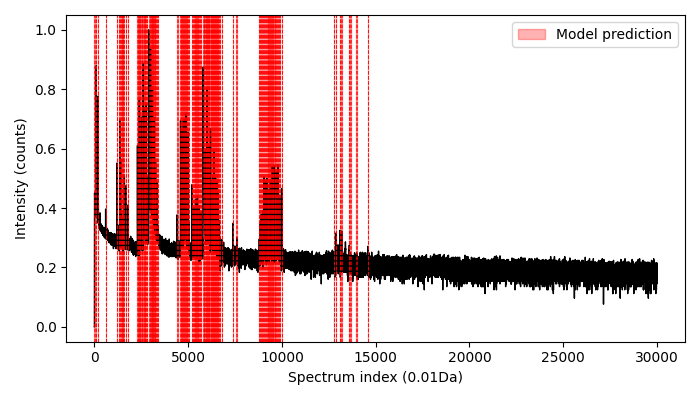

In [ ]:
# set the zoom in m/c range
plot_max = 30000 # in 0.01 Da
plot_min = 0
bin_width = 0.01
peak_pred_ = peak_pred[(peak_pred[:,0] < plot_max) & (peak_pred[:,0] >plot_min)]


# Create the plot
fig, ax = plt.subplots(figsize=(7, 4))

# Plot the spectrum
x = 0.01 * torch.linspace(plot_min,plot_max, plot_max - plot_min)

ax.plot(x[...,None], spectrum_log[..., plot_min:plot_max].T, 'k-', linewidth=1)


# Add color boxes for each peak range
# Add vertical lines to show the boundaries of ranges

for start, end in peak_pred_:
    ax.axvspan(start*0.01, end*0.01, alpha=0.3, color='red',label='Model prediction' if start == peak_pred_[0][0] else "")
for start, end in peak_pred_:
    ax.axvline(start*0.01, color='red', linestyle='--', alpha=0.7, lw = 0.7)
    ax.axvline(end*0.01, color='red', linestyle='--', alpha=0.7, lw = 0.7)

# Set labels and title
ax.set_xlabel('Mass to charge ratio (Da)')
ax.set_ylabel('Intensity in log scale normalized(counts)')
# Adjust the plot layout
plt.tight_layout()
plt.legend()

In [ ]:
# rng_col = apav.RangeCollection()
from peak_detection.RangingNN.apav_ranges import RangeCollection as RC
from peak_detection.RangingNN.apav_ranges import Range

rng_col = RC()

bin_width = 0.01
for p in peak_pred:
    p[p<0]=0
    rng_col.add(Range("X", (float(p[0]*bin_width), float(p[1]*bin_width))))

In [ ]:
# export the ranges to RRNG file
rng_col.to_rrng('/srv/home/jwei74/APT_ML/ranging/VALIDATION/R6025_272235_RangingNN.RRNG')
#rng_col.to_rrng('/srv/home/jwei74/APT_ML/ranging/VALIDATION/UWPIDU_RangingNN.RRNG')
#rng_col.to_rrng('/srv/home/jwei74/APT_ML/ranging/VALIDATION/UWPIDW_RangingNN.RRNG')
